### Processing handwritten equation with OpenCV

In [1]:
import numpy as np
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt
from datetime import datetime

In [23]:
image = cv.imread('7+3.png')
untitled = cv.imread('sdfasf.jpg')
image_working_copy = image.copy()

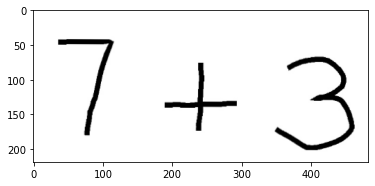

In [6]:
plt.imshow(image)

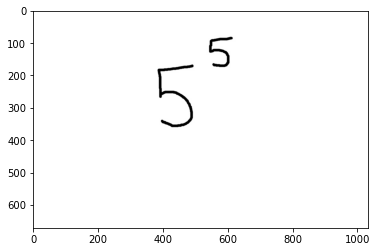

In [7]:
plt.imshow(untitled)

In [8]:
imgray = cv.cvtColor(image_working_copy, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 100, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

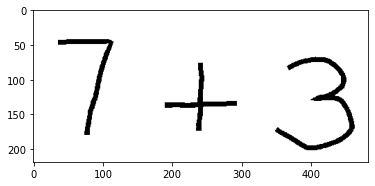

In [9]:
plt.imshow(thresh, cmap = 'gray')

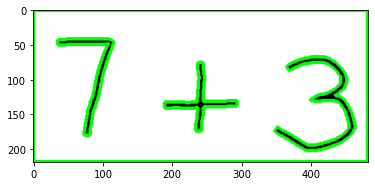

In [10]:
image_with_contours = cv.drawContours(image_working_copy, contours, -1, (0,255,0), 3)

plt.imshow(image_with_contours)

In [3]:
def find_contours(path):
    """
    Finds all contours in a given picture.
    Args:
        path (str): path to image
    Returns:
        contours: Detected contours. Each contour is stored as a vector of points.
        hierarchy: Optional output vector, containing information about the image topology.
    """
    img = cv.imread(path)
    imgray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(imgray, 100, 255, 0)
    return cv.findContours(
        thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

In [4]:
contours, hierarchy = find_contours('sdfasf.jpg')

In [5]:
# create list of tuples
boundingRects = [cv.boundingRect(contour) for contour in contours]

In [6]:
# sort list of tuples by first element (which is x coordinate), that way we get bounding boxes in right order 
boundingRects.sort()

In [7]:
#check
boundingRects = boundingRects[1:]

boundingRects 

[(65, 186, 69, 116),
 (170, 131, 55, 80),
 (180, 147, 16, 23),
 (274, 231, 45, 51),
 (392, 183, 65, 108),
 (500, 128, 51, 68),
 (596, 222, 61, 61),
 (702, 198, 57, 111),
 (710, 206, 29, 33),
 (714, 248, 37, 53),
 (800, 248, 45, 9),
 (895, 199, 12, 105)]

In [22]:
boundingBoxes_filtered = remove_overlapping_bounding_boxes(boundingRects)
boundingBoxes_filtered

[(65, 186, 69, 116),
 (170, 131, 55, 80),
 (274, 231, 45, 51),
 (392, 183, 65, 108),
 (500, 128, 51, 68),
 (596, 222, 61, 61),
 (702, 198, 57, 111),
 (800, 248, 45, 9),
 (895, 199, 12, 105)]

In [54]:
boundingBoxes_filtered[0]

(384, 167, 112, 194)

In [58]:
exponent_filter = check_exponent(boundingBoxes_filtered)

exponent_filter

[True, False, False, True, False, False, False, False]

In [53]:
(x, y, w, h) = boundingBoxes_filtered[0]

In [46]:
rect_img = cv.rectangle(untitled, (x-10, y-10), (x+w+10, y+h+10), (255, 0, 0), 3)

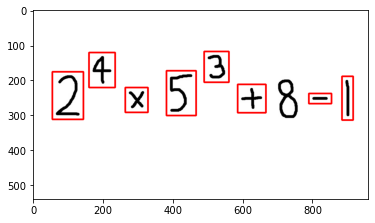

In [47]:
plt.imshow(rect_img)

In [20]:
def overlapping_axes(coord1, delta1, coord2, delta2):
    """Checks wether 2 bounding boxes overlap over given axes
    Args:
        coord1 (int): start coordinate of axes for first bounding box
        delta1 (int): size of first bounding box along axes
        coord2 (int): coordinate of start axes for second bounding box
        delta2 (int): size of second bounding box along axes
    Returns:
        bool: true if they overlap else false
    """
    if coord1 <= coord2 + delta2 and coord1 >= coord2:
        return True
    if coord1 + delta1 <= coord2 + delta2 and coord1 + delta1 >= coord2:
        return True
    if coord2 <= coord1 + delta1 and coord2 >= coord1:
        return True
    if coord2 + delta2 <= coord1 + delta1 and coord2 + delta2 >= coord1:
        return True

    return False

In [21]:
def remove_overlapping_bounding_boxes(boundingRects):
    """Finds all contours and chooses ones that best contour given characters.
    Args:
        boundingRects (list): list of bounding boxes to check and remove if overlapping
    Returns:
        list: list of bounding boxes for filtered contours
    """

    # If 2 bounding boxes are overlapping, take the bigger one
    for i in range(len(boundingRects)):
        if boundingRects[i] is None:
            continue
        for j in range(i + 1, len(boundingRects)):
            if boundingRects[j] is None:
                continue
            x1, y1, width1, height1 = boundingRects[i]
            x2, y2, width2, height2 = boundingRects[j]

            if overlapping_axes(x1, width1, x2, width2) and overlapping_axes(y1, height1, y2, height2):
                if width1 * height1 > width2 * height2:
                    boundingRects[j] = None
                else:
                    boundingRects[i] = None
                    break

    return [bounding for bounding in boundingRects if bounding is not None]

In [57]:
def check_exponent(bounding_boxes):
    """Checks difference between vertical coordinate y among two bounding boxes.
    Args:
        bounding_boxes (list): bounding box to be used for comparison
    Returns:
        boolean: True if according to a condition exponent is recognized. Otherwise returns False."""
    
    main_anchor = bounding_boxes[0][1] + bounding_boxes[0][3]
    remaining_anchors = [bounding_box[1]+bounding_box[3] for bounding_box in bounding_boxes[1:]]
    
    mask = []
    
    is_exponent = None
    delta_y = None
    
    for anchor in remaining_anchors:
        delta_y = main_anchor - anchor
        
        if delta_y > 70:
            is_exponent = True
        else:
            is_exponent = False
        
        mask.append(is_exponent)
        
    return mask

In [95]:
def crop_bounding_box(image, bounding_boxes):
    """Crops images given their bounding boxes
    Args:
        image (np.ndarray): np.ndarray representation of the image
        bounding_boxes (list): bounding box to be used for cropping
    Returns:
        np.ndarray: np.ndarray representation of the cropped image
    """
    cropped_images = list()
    
    for i in range(0, len(bounding_boxes)):
        x, y, w, h = bounding_boxes[i]
        cropped_image = image[(y-10):(y+h+10), (x-10):(x+w+10)]
        cropped_images.append(cropped_image)
    
    return cropped_images

In [96]:
cropped_imgs = crop_bounding_box(image, boundingRects)

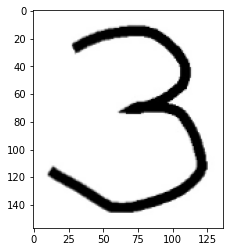

In [100]:
plt.imshow(cropped_imgs[2])

In [77]:
# define a function that will resize images to predetermined standard size, which is 150x150 in our case

def resize_images(images_list, pixels_height = 150, pixels_width = 150):
    """This function resizes all images in the given input list to desired 
    pixels height and pixels width.
    
    Args:
        images_list (list): List of images in . 
        pixels_height (int): Desired height of the resized image in pixels.
        pixels_width (int): Desired width of the resized image in pixels.
    Returns:
        resized_imgs (list): List of resized images.
    """
    resized_imgs = []
    
    for image in images_list:
        try:
            resized_image = cv.resize(image, (pixels_height, pixels_width))
            resized_imgs.append(resized_image)
        except:
            break
            
    return resized_imgs

In [78]:
resized_images = resize_images(cropped_imgs)

In [508]:
def plot_imgs(imgs_list):
    """This function plots images from a list on a grid.
    
    Args:
        imgs_list (list): List of images.
    """
    
    imgs_no = len(imgs_list)
    img_count = 0
    
    fig, axes = plt.subplots(nrows = 1, ncols = imgs_no, figsize = (10,10))
    
    for i in range(imgs_no):        
        if img_count <= imgs_no:
            axes[i].imshow(imgs_list[img_count])
            img_count+=1

In [79]:
resized_images_array = np.array(resized_images)

# check for expected output
resized_images_array.shape

(3, 150, 150, 3)

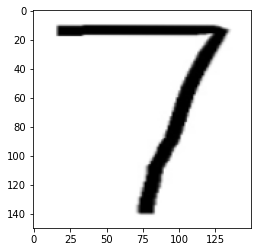

In [83]:
plt.imshow(resized_images[2])

In [322]:
def save_array(numpy_array):
    """This function saves numpy array to a .npy file.
    
    Args:
        numpy_array (ndarray): Array to save in the form of .npy file. 
    """
    np.save(r'output\output_array_{}.npy'.format(datetime.now().strftime("%d_%m_%Y_%H%M%S")), numpy_array)

In [66]:
save_array(resized_images_array)

In [492]:
"""define a pipeline function that takes all necessary steps to proceess handwritten equation picture 
and prepares it for model prediction"""

def equation_image_preprocess_pipeline(image_path):
    print('Processing started!')
    
    image = cv.imread(image_path)
    
    # find all conours in a given picture
    print('Extracting contours from the image!...')
    contours, hierarchy = find_contours(image_path)
    print('Contours extracted!...')
    
    # create list of bounding boxes (list of tuples)
    print('Creating bounding boxes around contours!...')
    boundingBoxes = [cv.boundingRect(contour) for contour in contours]
    
    # sort list of bounding boxes by first element of tuples (which is x coordinate) 
    boundingBoxes.sort()
    
    # drop first element (bounding box that frames whole image)
    boundingBoxes = boundingBoxes[1:]
    
    # remove overlapping bounding boxes
    boundingBoxes_filtered = remove_overlapping_bounding_boxes(boundingBoxes)
    print('Bounding boxes created!...')
    
    # crop images given their bounding boxes
    print('Cropping images!...')
    cropped_imgs = crop_bounding_box(image, boundingBoxes_filtered)
    
    # resize images to right size for prediction
    resized_imgs = resize_images(cropped_imgs)
    print('Images resized to right format!...')
    
    # plot resized images
    print('Plotting images!...')
    plot_imgs(resized_imgs)

    # create an numpy array of resized images
    resized_imgs_array = np.array(resized_imgs)
    
    # save numpy array to a .npy file
    save_array(resized_imgs_array) 
    print('Array of images saved to output! Processing done!')

In [521]:
# test images paths
img_path_1 = '2+2.jpg'
img_path_2 = '3+8.jpeg'
img_path_3 = '7+3.png'
img_path_4 = '15+100.JPG'
img_path_5 = '87+95.jpg'
img_path_6 = '189+82.jpg'
img_path_7 = '2+35.jpg'
img_path_8 = '24-23.jpg'

Processing started!
Extracting contours from the image!...
Contours extracted!...
Creating bounding boxes around contours!...
Bounding boxes created!...
Cropping images!...
Images resized to right format!...
Plotting images!...
Array of images saved to output! Processing done!


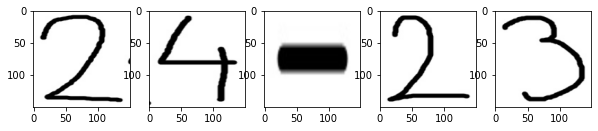

In [522]:
equation_image_preprocess_pipeline(img_path_8)